<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/0509_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필사 #1 [NLP 언제까지 미룰래? 일단 들어와!!] #4. word embedding

In [53]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/test_x.csv')
submission = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/sample_submission.csv', index_col=False)

## Embedding이란?

* 비슷한 의미를 내포하고 있는 토큰들은 서로 가깝게, 그렇지 않은 토큰들은 서로 멀리 위치시키는 것이 목적
* 검색 시스템, 감성 분석에서 훌륭한 임베딩 수행이 전체 문제 해결에 많은 영향을 미침
* 임베딩 또한 하나의 모델을 의미하며 훈련이 필요
  - 데이터, 시간 충분 -> 소지한 데이터에 특화된 임베딩 모델 학습 가능
  - 보통 pre_trained embedding model을 가져와서 사용

## 1. Keras Embedding Layer

* 가장 쉽고 빠르게 네트워크 모델에 임베딩 층을 주입할 수 있는 방식
* 무작위로 특정 차원으로 입력 벡터들을 뿌린 후 학습을 통해 가중치들을 조정해 나가는 방식
  
  => 단어 사이의 관계를 반영하는 방법이 아님

* 적용 : keras 코드로 구현

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer() # keras의 vectorizing 함수 호출
    tokenizer.fit_on_texts(train_text) # train 문장에 fit
    train_X_seq = tokenizer.texts_to_sequences(train_text) # 각 토큰들에 정수 부여
    vocab_size = len(tokenizer.word_index) + 1 # 모델에 알려줄 vocabulary의 크기 계산
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len) # 설정한 문장의 최대 길이만큼 padding
    
    return X_train, vocab_size, tokenizer

train_X, vocab_size, tokenizer = text2sequence(train['text'], max_len = 100)

vocab_size :  42331


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

max_len=100

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_len))

## 2. word2vec

* 주변 단어와의 관계를 통해 해당 단어의 의미적 특성을 파악


### word2vec embedding matrix를 keras의 embedding에 주입하는 과정

1. 구글의 사전 훈련된 word2vec bin 파일을 다운로드

2. gensim 모듈과 bin파일을 활용해 word2vec 모델을 로드

In [57]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/GoogleNews-vectors-negative300.bin.gz', binary = True)

3. vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장

In [58]:
import numpy as np

In [59]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(tokenizer.word_index): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print("word2vec에 없는 단어입니다.")
        break

word2vec에 없는 단어입니다.


4. keras embedding layer에 embedding_matrix를 가중치로 주어 이용

In [60]:
max_len = 100
model = Sequential()
model.add(Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = max_len))

## 3. glove

* word2vec의 단점 : 사용자가 지정한 주변 단어의 개수에 대해서만 학습이 이루어지기 때문에 데이터 전체에 대한 정보를 담기 어려움
  
  -> glove가 보완 : 각 토큰들 간의 유사성은 그대로 가져가면서 데이터 전체에 대한 빈도를 반영

### glove embedding matrix를 keras의 embedding matrix에 주입하는 방법

1. 사전 훈련된 벡터를 갖고 있는 txt 파일을 다운로드

2. txt 파일에 있는 단어와 벡터들을 glove dictionary에 저장

In [61]:
2. # load the whole embedding into memory
glove = dict()
f = open('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/glove.txt')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove[word] = vector
f.close()

3. vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장

In [62]:
embedding_matrix = np.zeros((vocab_size, 100)) #100차원의 임베딩 매트릭스 생성

for index, word in enumerate(tokenizer.word_index): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in glove: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = glove[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        print("glove 없는 단어입니다.")
        break

glove 없는 단어입니다.


4. keras embedding layer에 embedding_matrix를 가중치로 주어 이용

In [63]:
max_len = 100
model = Sequential()
model.add(Embedding(vocab_size, 100,weights = [embedding_matrix], input_length = max_len))

## 4. Fasttext

* 단어 단위가 아닌 sub 단어를 단위로 사용
> word2vec -> "apple" 학습
>
> FastText -> "ap", "pp", "pl", "le" 학습

* 장점 : 미리 학습되지 않은 단어들에 대한 vector도 표현

In [3]:
pip install fasttext

     |████████████████████████████████| 68 kB 4.1 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3140346 sha256=d225426404cbb4fe5a021765a0d02c6b821d6d9233a7e9d641f7a86c06d66b57
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


1. 사전 훈련된 bin 파일을 다운로드(glove에서 썼던 링크와 동일)

2. vec 파일을 gensim을 활용하여 읽어오기

In [70]:
from gensim.models.keyedvectors import KeyedVectors
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/ESAA/2022-1/월요일 스터디 세션/220509/fasttext.bin', binary = True)

3. vocabulary에 있는 토큰들의 벡터를 가져와 embedding matrix에 저장

In [68]:
embedding_matrix = np.zeros((vocab_size, 300)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocabulary): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in word2vec: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = word2vec[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[index] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.

4. keras embedding layer에 embedding_matrix를 가중치로 주어 이용

In [69]:
max_len = 100
model = Sequential()
model.add(Embedding(vocab_size, 300,weights = [embedding_matrix], input_length = max_len))

# 필사#2 [NLP 언제까지 미룰래? 일단 들어와!!] #5. Modeling(완)

## Modeling

* 현재 ML에서 주로 사용되는 SVM, RF, Boosting Machine등을 활용하여 간단한 NLP 태스크를 해결이 가능하지만 복잡한 문제를 해결하기에는 한계 존재
  
  -> 기본적으로 네트워크 모델을 이용하여 NLP 문제를 해결

## 1. RNN

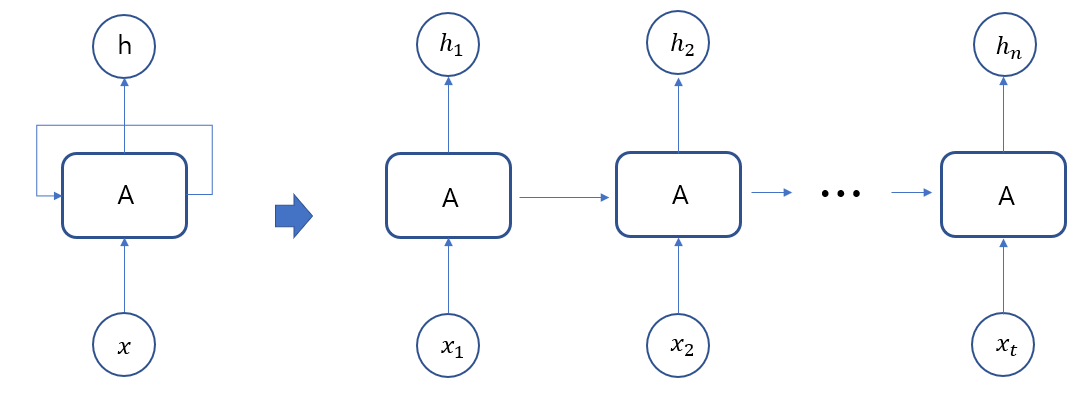

* RNN : 순차적인 구조
  
  -> 연산에 많은 시간 소요, 네트워크의 고질적인 문제인 역전파 소실 문제가 발생
* x1에 대한 정보가 h1 이라는 출력뿐만 아니라 다음 x2에 대한 정보와 같이 입력이 되는 구조
* A에 해당하는 부분 : LSTM과 GRU 등을 사용

## 2. LSTM

* RNN 구조에서 특정 시점의 정보를 다음 시점으로 전달할 때 얼만큼의 정보를 전달할지 결정하는 역할 수행
* 기존 RNN에 cell state를 추가
  - cell state : 입력들의 정보를 선별하여 다음 출력으로 내보내는 게이트 역할
  
  -> 불필요한 정보들을 걸러내어 매끄러운 진행이 가능
  
  -> 역전파 소실 문제를 줄여 성능이 증가

## 3. GRU

* LSTM의 복잡한 구조를 보다 간결하게 보완한 모델
* LSTM의 장점을 가져오면서 속도적인 부분을 개선하여 더욱 빠른 속도로 비슷한 성능을 냄

## 4. Attention

* RNN 모델의 구조적인 한계를 극복한 모델
  - RNN 모델 사용 시 발생하는 문제점
   - 입력으로 이용된 정보들을 순차적으로 고정 길이로 압축하면서 발생하는 정보의 손실
   - 역전파 소실
* 어떤 토큰의 정보가 가장 큰 도움을 줬는지 알 수 있음
* 뒤이어 나온 자연어 처리의 세기적 발견인 Transformer(attention is all you need)의 핵심 알고리즘
  - 둘에 대한 이해가 바탕이 되어야 다양한 문제에서 SOTA를 자랑하는 ELMO, BERT, GPT 등의 방법론들을 이해할 수 있음

## 5. 대회 적용

In [4]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,734 kB]
Hit:14 http://ppa.la

In [5]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [6]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1213k      0  0:00:01  0:00:01 --:--:-- 5357k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [7]:
import konlpy

* 데이터 로드 다음 단계부터 적용

### 간단한 전처리 + 형태소 분석

In [41]:
!pip install tqdm

In [46]:
from konlpy.tag import Okt
from tqdm import tqdm
import re

def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null']
    tokenizer = Okt()
    
    for text in tqdm(text_list):
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        token = tokenizer.morphs(txt)
        token = [t for t in token if t not in stopwords or type(t) != float]
        
    return token, tokenizer

train['token'], okt = text_preprocessing(train['text'])

100%|██████████| 54879/54879 [18:22<00:00, 49.77it/s]


ValueError: ignored

### vectorization

In [75]:
def text2sequence(train_text, max_len=1000):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len)
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['token'], max_len = 100)
print(train_X.shape, train_y.shape)

### Embedding

In [74]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)
embedding_matrix = np.zeros((vocab_size, 300))

for index, word in enumerate(tokenizer.word_index):
    if word in word2vec:
        embedding_vector = word2vec[word] 
        embedding_matrix[index] = embedding_vector 
    else:
        print("word2vec에 없는 단어입니다.")
        break

### Modeling

In [76]:
def LSTM(vocab_size, max_len=1000):
    model = Sequential()
    model.add(Embedding(vocab_size, 300,weights = [embedding_matrx], input_length = max_len)) #임베딩 가중치 적용 코드
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model

## 번외? test

* 테스트 시 고려해야할 부분
  1. train에 사용했던 형태소 분석기를 객체로 저장하여 test에도 이용해야 함
  2. train에 사용했던 vectorizer를 객체로 저장하여 test에도 이용해야 함
  3. train에 사용했던 Embedding matrix를 객체로 저장하여 test에도 이용해야 함